In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error


In [2]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv') 

In [3]:
print(links.shape)
links.head()

(9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
print(ratings.shape)
ratings.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
print(tags.shape)
tags.head()

(3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


## EDA

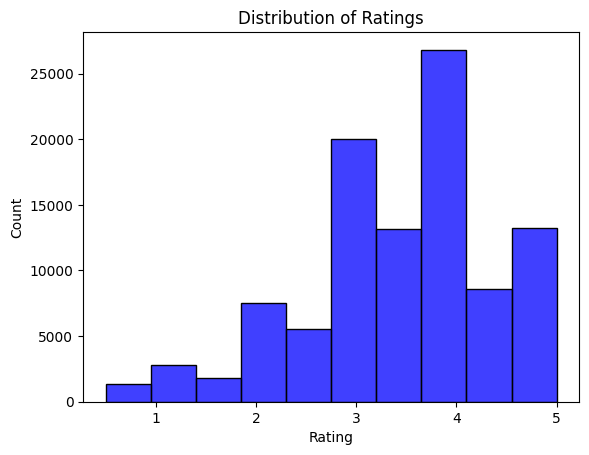

In [8]:
# 1. Ratings Distribution
sns.histplot(ratings['rating'], bins=10, kde=False, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

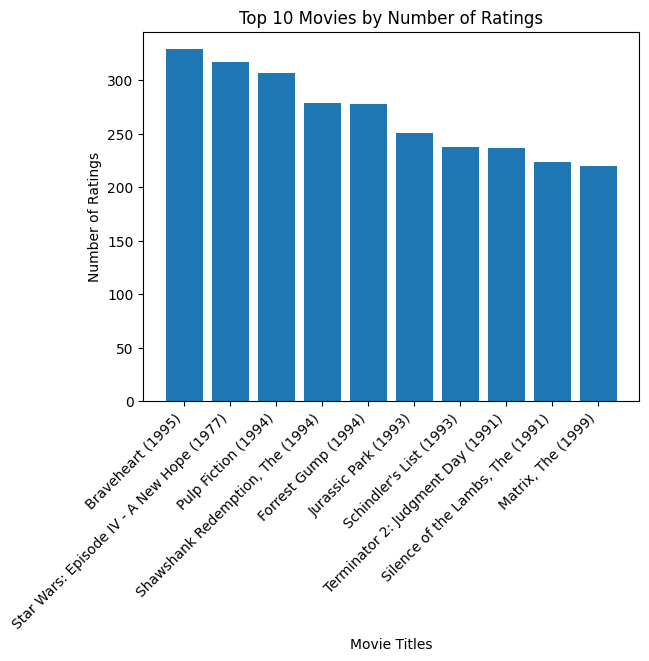

In [9]:
# 2. Top 10 Movies with the Most Ratings
top_movies = ratings['movieId'].value_counts().head(10).index
top_movie_titles = movies[movies['movieId'].isin(top_movies)]
top_movie_ratings = ratings[ratings['movieId'].isin(top_movies)]['movieId'].value_counts()

plt.bar(top_movie_titles['title'], top_movie_ratings)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Movies by Number of Ratings')
plt.ylabel('Number of Ratings')
plt.xlabel('Movie Titles')
plt.show()

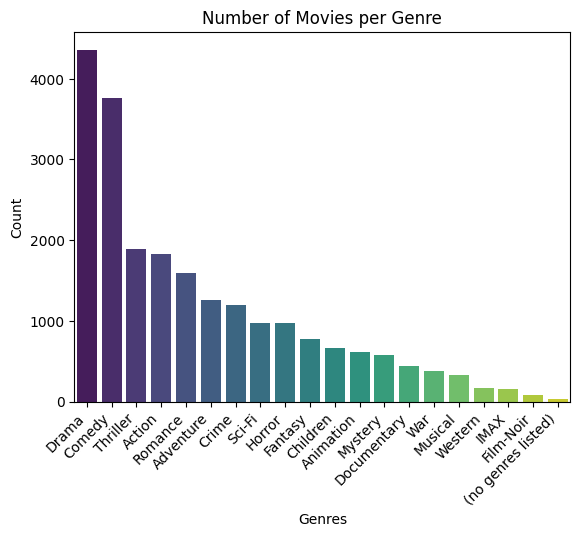

In [10]:
movies['genres'] = movies['genres'].str.split('|')
genres_expanded = movies.explode('genres')
genres_count = genres_expanded['genres'].value_counts()

sns.barplot(x=genres_count.index, y=genres_count.values, palette='viridis')
plt.title('Number of Movies per Genre')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.xlabel('Genres')
plt.show()

In [11]:
# Calculate Average Rating
avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
avg_ratings.columns = ['movieId', 'average_rating']
avg_ratings.head()

,movieId,average_rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429


In [12]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [13]:
merged = pd.merge(avg_ratings,movies)
merged.head()

,movieId,average_rating,title,genres
0,1,3.920930,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,3.431818,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,3.259615,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,2.357143,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,3.071429,Father of the Bride Part II (1995),[Comedy]


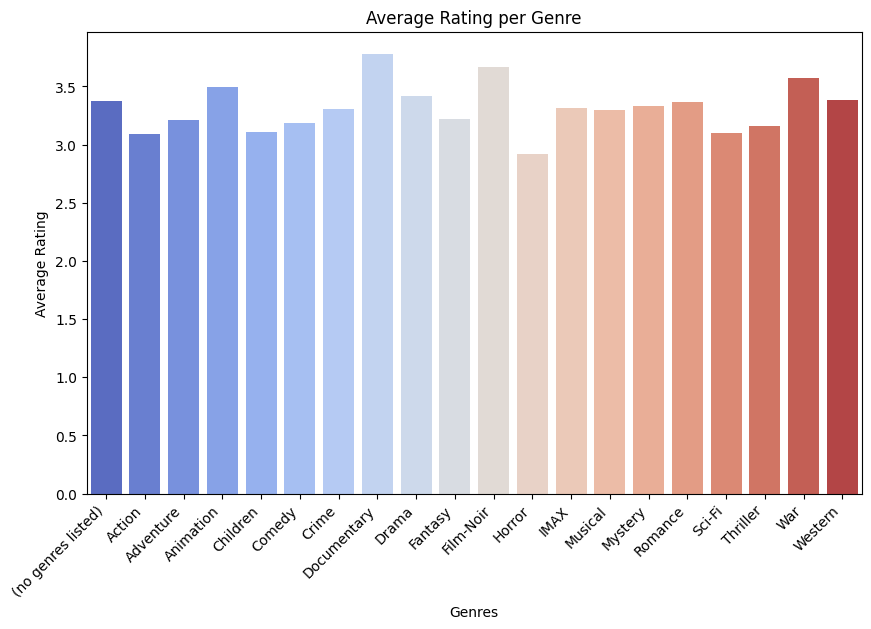

In [14]:
merged_exploded = merged.explode('genres')

genre_avg_ratings = merged_exploded.groupby('genres')['average_rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=genre_avg_ratings, x='genres', y='average_rating', palette='coolwarm')
plt.title('Average Rating per Genre')
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.show()


## Preprocessing

In [15]:
# Handling the missing values 
links.isnull().sum()


movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [16]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [17]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [18]:
tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [19]:
ratings['n_rating'] = (ratings['rating'] - ratings['rating'].min()) / (ratings['rating'].max() - ratings['rating'].min())

In [20]:
# Step 1: Create the user-item interaction matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Step 2: Fill missing values (e.g., with 0 for no interaction or the mean rating for imputation)
user_item_matrix_filled = user_item_matrix.fillna(0)  # Replace NaNs with 0 (no interaction)

# Display the user-item interaction matrix
print("User-Item Interaction Matrix:")
user_item_matrix_filled.head()


User-Item Interaction Matrix:


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
user_item_matrix = user_item_matrix.fillna(0)  # Replace NaNs with zeros


In [22]:
user_means = user_item_matrix.mean(axis=1)
normalized_matrix = user_item_matrix.sub(user_means, axis=0)
normalized_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,3.895825,-0.104175,3.895825,-0.104175,-0.104175,3.895825,-0.104175,-0.104175,-0.104175,-0.104175,...,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175
2,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,...,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775
3,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,...,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770
4,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,...,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980
5,3.983546,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,...,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454


In [23]:
from scipy.sparse.linalg import svds

# Perform SVD, keeping k latent factors
U, sigma, Vt = svds(normalized_matrix.values, k=100)

# Convert sigma (singular values) into a diagonal matrix
sigma = np.diag(sigma)


In [24]:
reconstructed_matrix = np.dot(np.dot(U, sigma), Vt)

# Add back user means to denormalize
reconstructed_matrix = reconstructed_matrix + user_means.values[:, np.newaxis]
reconstructed_matrix = np.clip(reconstructed_matrix, 0, 5)



In [25]:
predicted_ratings = pd.DataFrame(reconstructed_matrix, index=user_item_matrix.index, columns=user_item_matrix.columns)
predicted_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,3.471018,0.298326,3.131096,0.229074,0.089782,3.805926,0.164404,0.114733,0.199571,0.000000,...,0.116511,0.101513,0.131509,0.131509,0.116511,0.131509,0.116511,0.116511,0.116511,0.000000
2,0.354172,0.049318,0.000000,0.000000,0.106594,0.000000,0.030400,0.046609,0.046501,0.000000,...,0.033035,0.028441,0.037629,0.037629,0.033035,0.037629,0.033035,0.033035,0.033035,0.050858
3,0.086552,0.000000,0.073002,0.010519,0.112911,0.203215,0.081218,0.023242,0.027572,0.000000,...,0.008755,0.008909,0.008601,0.008601,0.008755,0.008601,0.008755,0.008755,0.008755,0.015282
4,1.165012,0.029818,0.295829,0.098927,0.515800,1.477334,0.606430,0.124794,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003518
5,1.990547,0.790265,0.000000,0.067894,0.159691,0.607638,0.236051,0.056216,0.000000,0.706197,...,0.004455,0.004197,0.004713,0.004713,0.004455,0.004713,0.004455,0.004455,0.004455,0.006007


## Predictions

In [26]:
user_id = 1  # Example user ID


In [27]:
user_ratings = predicted_ratings.loc[user_id]
ranked_movies = user_ratings.sort_values(ascending=False)


In [28]:
watched_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
recommendations = ranked_movies.drop(index=watched_movies)


In [29]:
recommendations = recommendations.reset_index().merge(movies, on="movieId", how="left")


In [30]:
print(recommendations.columns)


Index(['movieId', 1, 'title', 'genres'], dtype='object')


In [31]:
recommendations.rename(columns={1: 'predicted_rating'}, inplace=True)
print(recommendations[['movieId', 'title', 'predicted_rating']].head(10))


   movieId                                              title  \
0     4571            Bill & Ted's Excellent Adventure (1989)   
1     1639                                 Chasing Amy (1997)   
2      750  Dr. Strangelove or: How I Learned to Stop Worr...   
3     1200                                      Aliens (1986)   
4      454                                   Firm, The (1993)   
5     5218                                     Ice Age (2002)   
6       16                                      Casino (1995)   
7      455                                  Free Willy (1993)   
8     1961                                    Rain Man (1988)   
9     2355                               Bug's Life, A (1998)   

   predicted_rating  
0          2.042714  
1          2.000002  
2          1.997629  
3          1.970667  
4          1.955854  
5          1.920851  
6          1.810503  
7          1.691639  
8          1.683864  
9          1.641815  


## Evaluation

In [32]:
train, test = train_test_split(user_item_matrix, test_size=0.2, random_state=42)

In [33]:
# Assuming user_item_matrix is your original DataFrame
# Get the user and movie indices
user_ids = test.index
movie_ids = test.columns

# Ensure that user_ids and movie_ids are within the reconstructed matrix dimensions
user_id_map = {user_id: idx for idx, user_id in enumerate(user_item_matrix.index)}
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(user_item_matrix.columns)}

# Map the user and movie ids to their respective row and column indices in reconstructed_matrix
user_row_indices = [user_id_map[user_id] for user_id in user_ids if user_id in user_id_map]
movie_col_indices = [movie_id_map[movie_id] for movie_id in movie_ids if movie_id in movie_id_map]

# Use the indices to get the predicted ratings from the reconstructed matrix
test_predictions = reconstructed_matrix[np.ix_(user_row_indices, movie_col_indices)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test.values, test_predictions))
print("RMSE:", rmse)


RMSE: 0.24463035106862763


In [34]:
ratings.head()

,userId,movieId,rating,timestamp,n_rating
0,1,1,4.0,964982703,0.777778
1,1,3,4.0,964981247,0.777778
2,1,6,4.0,964982224,0.777778
3,1,47,5.0,964983815,1.000000
4,1,50,5.0,964982931,1.000000


In [35]:
predicted_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,3.471018,0.298326,3.131096,0.229074,0.089782,3.805926,0.164404,0.114733,0.199571,0.000000,...,0.116511,0.101513,0.131509,0.131509,0.116511,0.131509,0.116511,0.116511,0.116511,0.000000
2,0.354172,0.049318,0.000000,0.000000,0.106594,0.000000,0.030400,0.046609,0.046501,0.000000,...,0.033035,0.028441,0.037629,0.037629,0.033035,0.037629,0.033035,0.033035,0.033035,0.050858
3,0.086552,0.000000,0.073002,0.010519,0.112911,0.203215,0.081218,0.023242,0.027572,0.000000,...,0.008755,0.008909,0.008601,0.008601,0.008755,0.008601,0.008755,0.008755,0.008755,0.015282
4,1.165012,0.029818,0.295829,0.098927,0.515800,1.477334,0.606430,0.124794,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003518
5,1.990547,0.790265,0.000000,0.067894,0.159691,0.607638,0.236051,0.056216,0.000000,0.706197,...,0.004455,0.004197,0.004713,0.004713,0.004455,0.004713,0.004455,0.004455,0.004455,0.006007


## Feature Engineering

In [41]:
### Step 1: Extract Genres
# Convert genres string into a list of genres
movies['genres_list'] = movies['genres'].str.split('|')

# One-hot encode genres for machine learning compatibility
genres_dummies = movies['genres'].str.get_dummies('|')

# Add genres one-hot encoding to the dataframe
movies = pd.concat([movies, genres_dummies], axis=1)

### Step 2: Extract Year of Release
# Use regex to extract the year of release from the title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False)

# Handle missing years and convert to numeric type
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

### Step 3: Aggregate Tags
# Group tags by movieId, concatenating tags for each movie
tags_aggregated = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Merge aggregated tags back into the movies dataset
movies = movies.merge(tags_aggregated, on='movieId', how='left')

# Replace NaN tags with an empty string
movies['tag'] = movies['tag'].fillna('')

### Step 4: Combine Features
# Combine genres, year, and tags into a single column
movies['content'] = (
    movies['genres'] + ' ' + movies['year'].astype(str) + ' ' + movies['tag']
)

# Replace NaN values in 'content' with an empty string
movies['content'] = movies['content'].fillna('')

### Display Processed Data
print(movies[['movieId', 'title', 'genres', 'year', 'tag', 'content']].head())



   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres    year  \
0  Adventure|Animation|Children|Comedy|Fantasy  1995.0   
1                   Adventure|Children|Fantasy  1995.0   
2                               Comedy|Romance  1995.0   
3                         Comedy|Drama|Romance  1995.0   
4                                       Comedy  1995.0   

                                            tag  \
0                               pixar pixar fun   
1  fantasy magic board game Robin Williams game   
2                                     moldy old   
3                                                 
4                              pregnancy remake   

                                           

In [42]:
import streamlit as st

# App title
st.title("Movie Recommendation System")

# Sidebar filters
st.sidebar.header("Filters")

# Filter 1: Select User ID
user_id = st.sidebar.selectbox("User ID :", ["None"] + user_item_matrix.index.astype(str).tolist())

# Filter 2: Select Genre
available_genres = genres_count.index.tolist()
selected_genre = st.sidebar.selectbox("Genre :", ["None"] + available_genres)

# Filter 3: Select Movie
selected_movie = st.sidebar.selectbox("Movie :", ["None"] + movies['title'].unique().tolist())

# Subheader for recommendations
st.subheader("Top Recommendations")

# Step 1: Start with all movies and predictions
recommendations = predicted_ratings.reset_index().melt(id_vars="userId", var_name="movieId", value_name="predicted_rating")
recommendations['movieId'] = recommendations['movieId'].astype(int)
recommendations = recommendations.merge(movies, on="movieId", how="left")

# Step 2: Apply filters
if user_id != "None":
    user_id = int(user_id)
    user_ratings = predicted_ratings.loc[user_id]
    recommendations = recommendations[recommendations['movieId'].isin(user_ratings.index)]
    recommendations['predicted_rating'] = user_ratings.loc[recommendations['movieId']].values

if selected_genre != "None":
    recommendations = recommendations[recommendations['genres'].apply(lambda x: selected_genre in x)]

if selected_movie != "None":
    selected_movie_id = movies[movies['title'] == selected_movie]['movieId'].values[0]
    selected_movie_genres = movies[movies['movieId'] == selected_movie_id]['genres'].values[0]
    recommendations = recommendations[recommendations['genres'].apply(lambda x: any(genre in x for genre in selected_movie_genres))]
    recommendations = recommendations[recommendations['movieId'] != selected_movie_id]  # Exclude the selected movie itself

# Step 3: Remove duplicates and focus on genre diversity
recommendations = recommendations.drop_duplicates(subset="movieId").sort_values(by="predicted_rating", ascending=False)

# Step 4: Limit recommendations to top 10 with diversity
final_recommendations = []
seen_movies = set()
seen_genres = set()

for _, row in recommendations.iterrows():
    genres = row['genres']
    movie_id = row['movieId']
    if movie_id not in seen_movies and not any(genre in seen_genres for genre in genres):
        final_recommendations.append(row)
        seen_movies.add(movie_id)
        seen_genres.update(genres)
    if len(final_recommendations) >= 10:
        break

final_recommendations = pd.DataFrame(final_recommendations)

# Step 5: Display the recommendations
if final_recommendations.empty:
    st.write("No recommendations found. Try adjusting the filters.")
else:
    st.write("Top Movie Recommendations:")
    st.dataframe(final_recommendations[['title', 'genres', 'predicted_rating']])